In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize

## Importing Original Data

In [3]:
#IMPORTING CLEAN DATA USING RANDOM SAMPLING
train = pd.read_csv("projectData/train.csv", index_col=0)
train

,NEO_REFERENCE_ID,EST_DIA_IN_M(MIN),EST_DIA_IN_M(MAX),RELATIVE_VELOCITY_KM_PER_SEC,MISS_DIST.(KILOMETERS),PERIHELION_DISTANCE,APHELION_DIST,PERIHELION_TIME,MEAN_ANOMALY,MEAN_MOTION,HAZARDOUS,RISK_CATEGORY
2586,3529625,183.888672,411.187571,9.551351,27837396.0,0.783714,1.338152,2457843.686,141.435423,0.901929,False,1
29,3182169,50.647146,113.250461,3.838017,12937927.0,0.894596,1.275511,2458019.676,343.278084,0.872021,False,0
1677,3256739,253.837029,567.596853,6.477856,72234080.0,1.239713,2.001073,2457878.935,58.087470,0.477830,False,1
1833,3761549,334.622374,748.238376,18.027267,25818802.0,0.993025,1.966328,2458313.630,188.533899,0.547588,True,2
3632,3653520,69.912523,156.329154,24.300910,71082192.0,0.922122,3.114245,2457587.296,142.045632,0.343766,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2972,3648642,29.144390,65.168838,5.792225,6990692.5,0.617199,1.075825,2458100.540,233.401850,1.265477,False,0
3295,3711170,16.016034,35.812940,7.519185,2379111.0,0.982878,2.842302,2458019.666,352.858271,0.372624,False,0
271,3663258,10.581689,23.661375,8.965194,23981302.0,0.567981,1.290169,2457956.558,48.361916,1.100596,False,0
2522,3430406,221.082810,494.356193,5.432581,21529706.0,1.127583,3.110956,2458014.795,355.433174,0.319466,False,1


## Classification of Train by Logistic Regression

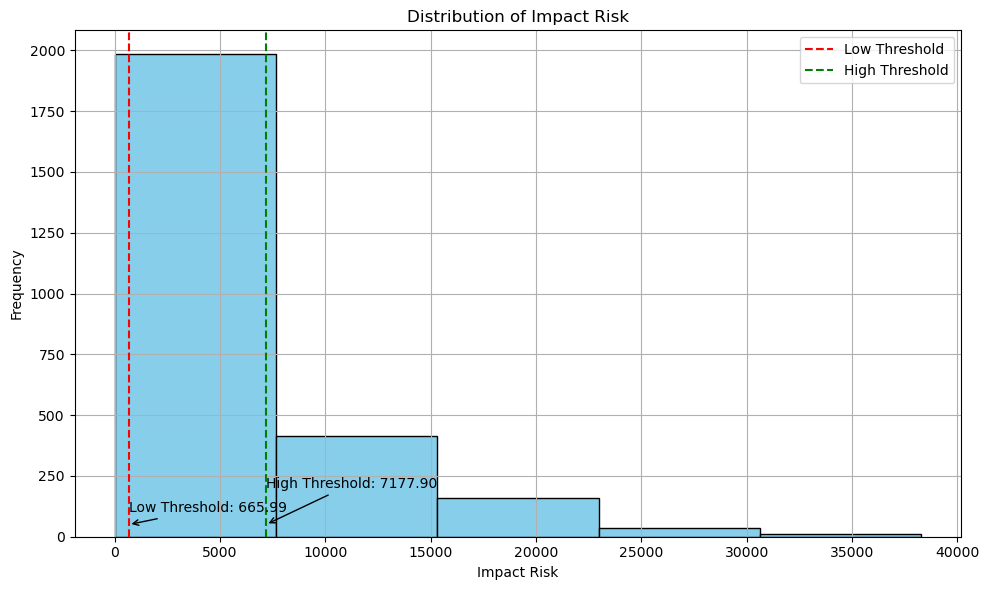

Low Threshold: 665.9877991585269
High Threshold: 7177.898347105189


In [4]:
train['IMPACT_RISK'] = train['EST_DIA_IN_M(MAX)'] * train['RELATIVE_VELOCITY_KM_PER_SEC']

# Check the distribution of IMPACT RISK
risk_values = train['IMPACT_RISK']
risk_values.describe()

# Determine thresholds based on the distribution
low_threshold = risk_values.quantile(0.25)
high_threshold = risk_values.quantile(0.75)

# Plotting the histogram with annotations for thresholds
plt.figure(figsize=(10, 6))
plt.hist(risk_values, bins=5, color='skyblue', edgecolor='black')
plt.axvline(low_threshold, color='r', linestyle='--', label='Low Threshold')
plt.axvline(high_threshold, color='g', linestyle='--', label='High Threshold')
plt.xlabel('Impact Risk')
plt.ylabel('Frequency')
plt.title('Distribution of Impact Risk')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Annotate the thresholds on the histogram
plt.annotate(f'Low Threshold: {low_threshold:.2f}', xy=(low_threshold, 50), xytext=(low_threshold + 5, 100),
             arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.annotate(f'High Threshold: {high_threshold:.2f}', xy=(high_threshold, 50), xytext=(high_threshold - 10, 200),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.show()

print('Low Threshold:', low_threshold)
print('High Threshold:', high_threshold)

# Create a new column 'Impact Risk Category' based on calculated thresholds
train['IMPACT_RISK_CATEGORY'] = pd.cut(train['IMPACT_RISK'], bins=[-np.inf, low_threshold, high_threshold, np.inf],labels=['Low', 'Medium', 'High'])


In [5]:
# Encoding the target variable (IMPACT RISK CATEGORY)
le = LabelEncoder()
train['IMPACT_RISK_ENCODED'] = le.fit_transform(train['IMPACT_RISK_CATEGORY'])

# Convert Hazardous to encoded
train['HAZARDOUS_ENCODED'] = train['HAZARDOUS'].astype(int)

# Features and target preparation
X = train[['IMPACT_RISK','HAZARDOUS_ENCODED']]
y = train['IMPACT_RISK_ENCODED']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

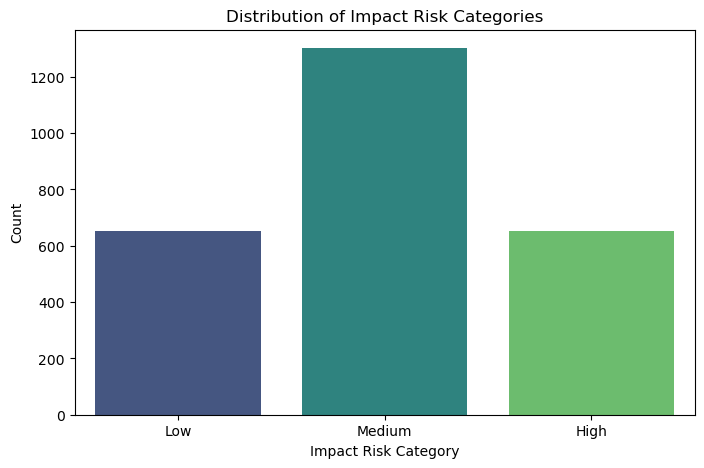

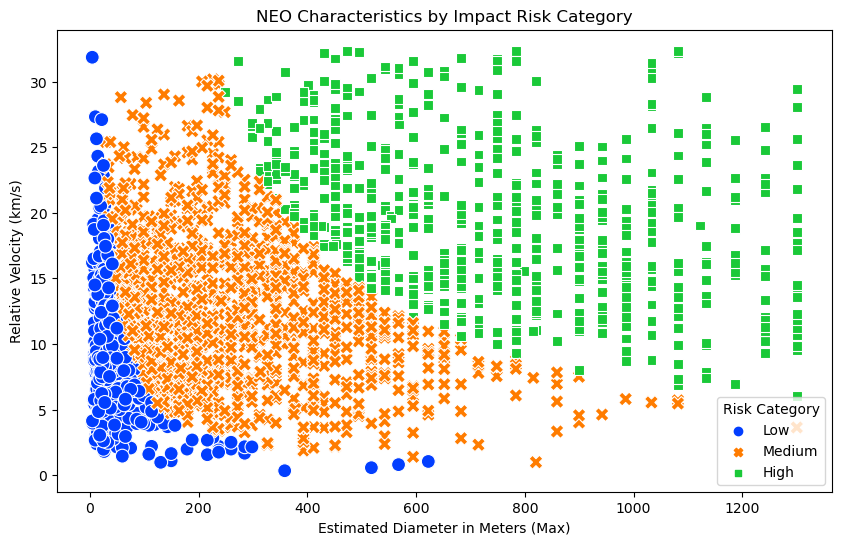

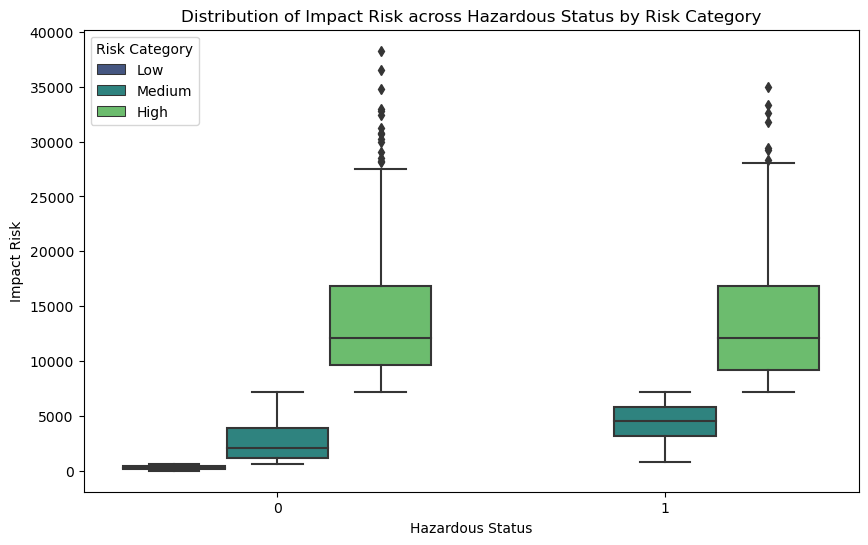

In [6]:
# Histogram of Impact Risk Categories
plt.figure(figsize=(8, 5))
sb.countplot(x='IMPACT_RISK_CATEGORY', data=train, palette='viridis')
plt.title('Distribution of Impact Risk Categories')
plt.xlabel('Impact Risk Category')
plt.ylabel('Count')
plt.show()

# Scatter Plot with Categories
plt.figure(figsize=(10, 6))
sb.scatterplot(data=train, x='EST_DIA_IN_M(MAX)', y='RELATIVE_VELOCITY_KM_PER_SEC', hue='IMPACT_RISK_CATEGORY', style='IMPACT_RISK_CATEGORY', palette='bright', s=100)
plt.title('NEO Characteristics by Impact Risk Category')
plt.xlabel('Estimated Diameter in Meters (Max)')
plt.ylabel('Relative Velocity (km/s)')
plt.legend(title='Risk Category')
plt.show()

# Violin Plot with Categories
plt.figure(figsize=(10, 6))
sb.boxplot(x='HAZARDOUS_ENCODED', y='IMPACT_RISK', hue='IMPACT_RISK_CATEGORY', data=train, palette='viridis')
plt.title('Distribution of Impact Risk across Hazardous Status by Risk Category')
plt.xlabel('Hazardous Status')
plt.ylabel('Impact Risk')
plt.legend(title='Risk Category')
plt.show()

## Importing Bootstrapping Data

In [7]:
#IMPORTING CLEANED TRAIN DATA USING BOOTSTRAP SAMPLING
bootstrapping_train = pd.read_csv("projectData/bootstrapping_train.csv", index_col = 0)
bootstrapping_train

,NEO_REFERENCE_ID,EST_DIA_IN_M(MIN),EST_DIA_IN_M(MAX),RELATIVE_VELOCITY_KM_PER_SEC,MISS_DIST.(KILOMETERS),PERIHELION_DISTANCE,APHELION_DIST,PERIHELION_TIME,MEAN_ANOMALY,MEAN_MOTION,HAZARDOUS,RISK_CATEGORY
0,3529625,183.888672,411.187571,9.551351,27837396.0,0.783714,1.338152,2457843.686,141.435423,0.901929,0.0,1
1,3256739,253.837029,567.596853,6.477856,72234080.0,1.239713,2.001073,2457878.935,58.087470,0.477830,0.0,1
2,3653520,69.912523,156.329154,24.300910,71082192.0,0.922122,3.114245,2457587.296,142.045632,0.343766,0.0,1
3,3071917,265.800000,594.346868,10.896092,33441924.0,1.163723,2.113338,2458007.502,356.709786,0.469918,0.0,1
4,3766293,23.150212,51.765448,13.348297,25744922.0,0.826214,1.215543,2457845.152,148.439096,0.955528,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3011,3455137,265.800000,594.346868,11.027074,39404808.0,0.601085,1.073320,2457864.451,175.046953,1.286644,1.0,2
3012,3626029,110.803882,247.765013,21.353475,64967668.0,0.562154,1.246986,2458122.294,220.469764,1.145621,1.0,2
3013,2140333,461.907460,1032.856481,23.062280,71000704.0,0.498651,1.425153,2457943.386,59.669559,1.044739,0.0,2
3014,3672899,127.219878,284.472297,12.747317,51848572.0,0.580992,1.433941,2457777.421,187.560356,0.974671,1.0,2


## Classification of Bootstrapping Train by Logistic Regression

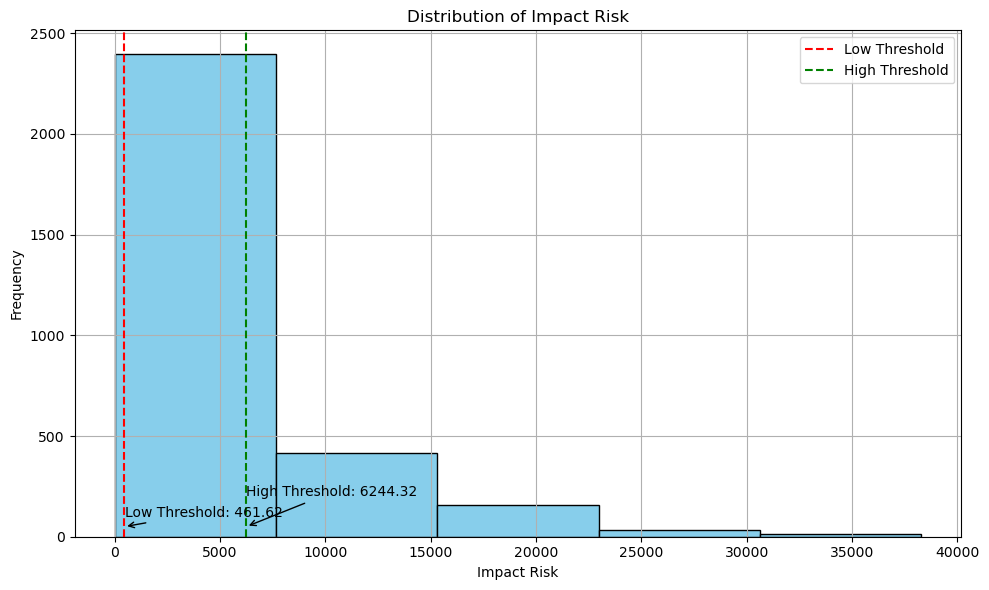

Low Threshold: 461.6232968152039
High Threshold: 6244.324294379966


In [8]:
bootstrapping_train['IMPACT_RISK'] = bootstrapping_train['EST_DIA_IN_M(MAX)'] * bootstrapping_train['RELATIVE_VELOCITY_KM_PER_SEC']

# Check the distribution of IMPACT RISK
risk_values = bootstrapping_train['IMPACT_RISK']
risk_values.describe()

# Determine thresholds based on the distribution
low_threshold = risk_values.quantile(0.25)
high_threshold = risk_values.quantile(0.75)

# Plotting the histogram with annotations for thresholds
plt.figure(figsize=(10, 6))
plt.hist(risk_values, bins=5, color='skyblue', edgecolor='black')
plt.axvline(low_threshold, color='r', linestyle='--', label='Low Threshold')
plt.axvline(high_threshold, color='g', linestyle='--', label='High Threshold')
plt.xlabel('Impact Risk')
plt.ylabel('Frequency')
plt.title('Distribution of Impact Risk')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Annotate the thresholds on the histogram
plt.annotate(f'Low Threshold: {low_threshold:.2f}', xy=(low_threshold, 50), xytext=(low_threshold + 5, 100),
             arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.annotate(f'High Threshold: {high_threshold:.2f}', xy=(high_threshold, 50), xytext=(high_threshold - 10, 200),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.show()

print('Low Threshold:', low_threshold)
print('High Threshold:', high_threshold)

# Create a new column 'Impact Risk Category' based on calculated thresholds
bootstrapping_train['IMPACT_RISK_CATEGORY'] = pd.cut(bootstrapping_train['IMPACT_RISK'], bins=[-np.inf, low_threshold, high_threshold, np.inf],labels=['Low', 'Medium', 'High'])

In [9]:
# Encoding the target variable (IMPACT RISK CATEGORY)
bootstrapping_train['IMPACT_RISK_ENCODED'] = le.fit_transform(bootstrapping_train['IMPACT_RISK_CATEGORY'])

# Convert Hazardous to encoded
bootstrapping_train['HAZARDOUS_ENCODED'] = bootstrapping_train['HAZARDOUS'].astype(int)

# Features and target preparation
X_bootstrapped = bootstrapping_train[['IMPACT_RISK','HAZARDOUS_ENCODED']]
y_bootstrapped = bootstrapping_train['IMPACT_RISK_ENCODED']

# Feature scaling
X_bootstrapped_scaled = scaler.fit_transform(X_bootstrapped)

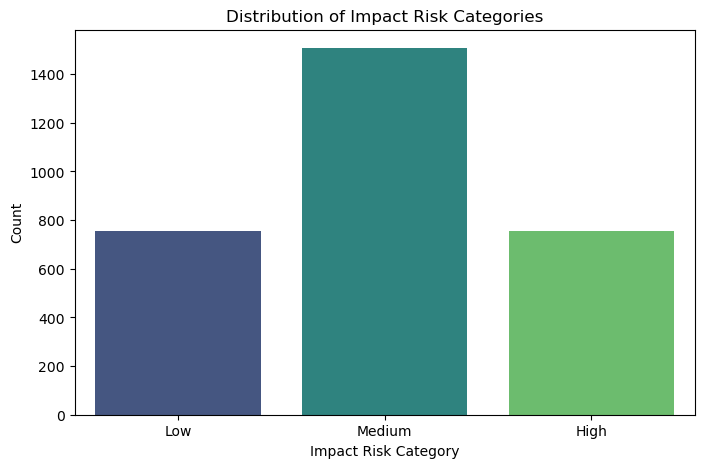

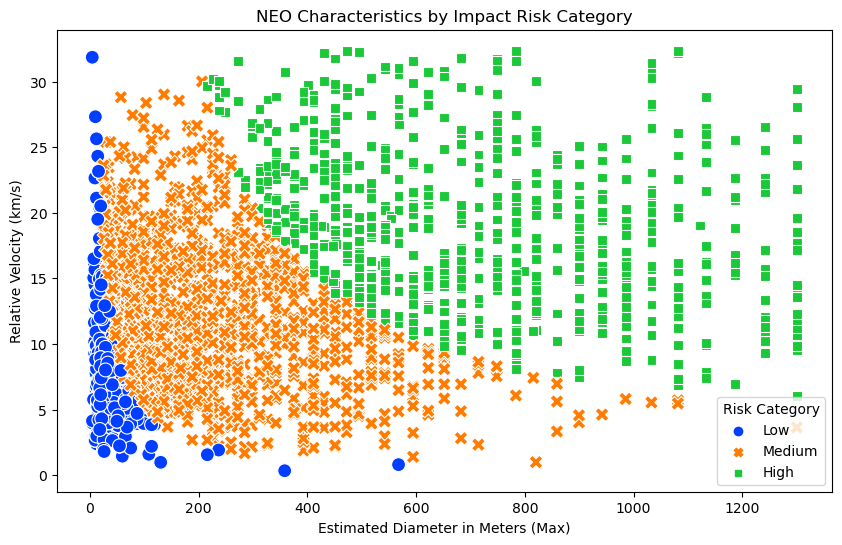

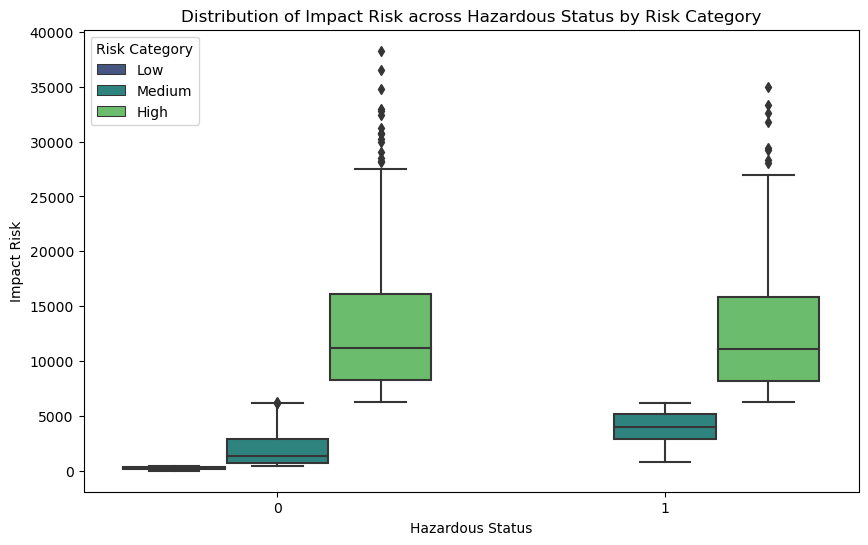

In [10]:
# Histogram of Impact Risk Categories
plt.figure(figsize=(8, 5))
sb.countplot(x='IMPACT_RISK_CATEGORY', data=bootstrapping_train, palette='viridis')
plt.title('Distribution of Impact Risk Categories')
plt.xlabel('Impact Risk Category')
plt.ylabel('Count')
plt.show()

# Scatter Plot with Categories
plt.figure(figsize=(10, 6))
sb.scatterplot(data=bootstrapping_train, x='EST_DIA_IN_M(MAX)', y='RELATIVE_VELOCITY_KM_PER_SEC', hue='IMPACT_RISK_CATEGORY', style='IMPACT_RISK_CATEGORY', palette='bright', s=100)
plt.title('NEO Characteristics by Impact Risk Category')
plt.xlabel('Estimated Diameter in Meters (Max)')
plt.ylabel('Relative Velocity (km/s)')
plt.legend(title='Risk Category')
plt.show()

# Violin Plot with Categories
plt.figure(figsize=(10, 6))
sb.boxplot(x='HAZARDOUS_ENCODED', y='IMPACT_RISK', hue='IMPACT_RISK_CATEGORY', data=bootstrapping_train, palette='viridis')
plt.title('Distribution of Impact Risk across Hazardous Status by Risk Category')
plt.xlabel('Hazardous Status')
plt.ylabel('Impact Risk')
plt.legend(title='Risk Category')
plt.show()

## Logistic Regression

In [11]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

# Train with original data
model.fit(X_scaled, y)
predictions_original = model.predict(X_scaled)

# Train with bootstrapped data
model.fit(X_bootstrapped_scaled, y_bootstrapped)
predictions_bootstrap = model.predict(X_bootstrapped_scaled)

In [12]:
def plot_confusion_matrix(y_true, y_pred, title):
    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Use Seaborn to create a heatmap for the confusion matrix
    plt.figure(figsize=(8, 6))
    sb.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [13]:
# Evaluation Metrics
def evaluate_predictions(y_true, y_pred, dataset_type):
    print(f"Results for {dataset_type} Dataset:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, average='weighted'))
    print("Recall:", recall_score(y_true, y_pred, average='weighted'))
    print("F1-Score:", f1_score(y_true, y_pred, average='weighted'))
    print()

# Evaluate both models
evaluate_predictions(y, predictions_original, 'Original')
evaluate_predictions(y_bootstrapped, predictions_bootstrap, 'Bootstrapped')

Results for Original Dataset:
Accuracy: 0.9692780337941628
Precision: 0.9713874476987447
Recall: 0.9692780337941628
F1-Score: 0.9695472239956578

Results for Bootstrapped Dataset:
Accuracy: 0.9618700265251989
Precision: 0.9656246967494898
Recall: 0.9618700265251989
F1-Score: 0.9623411647074598



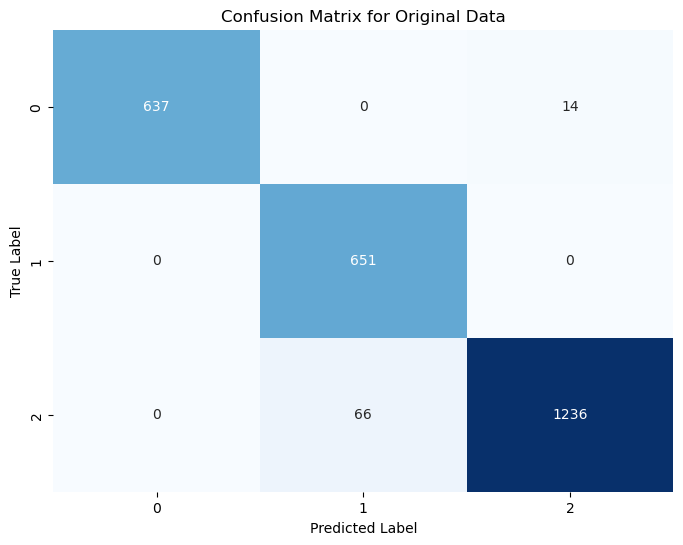

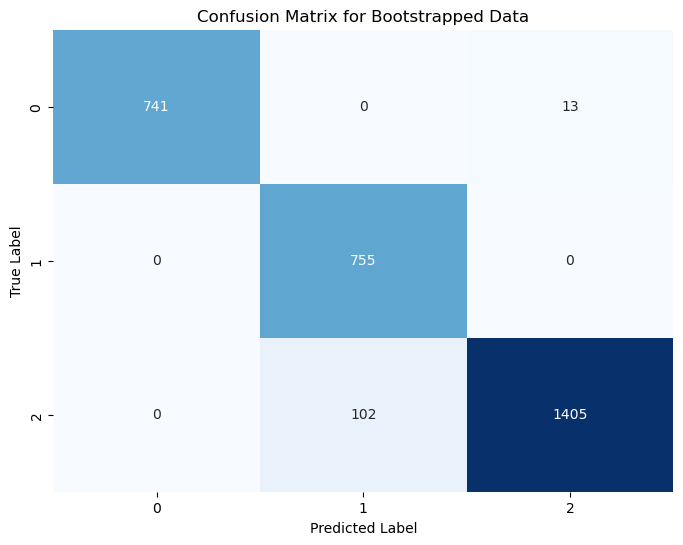

In [14]:
plot_confusion_matrix(y, predictions_original, 'Confusion Matrix for Original Data')
plot_confusion_matrix(y_bootstrapped, predictions_bootstrap, 'Confusion Matrix for Bootstrapped Data')

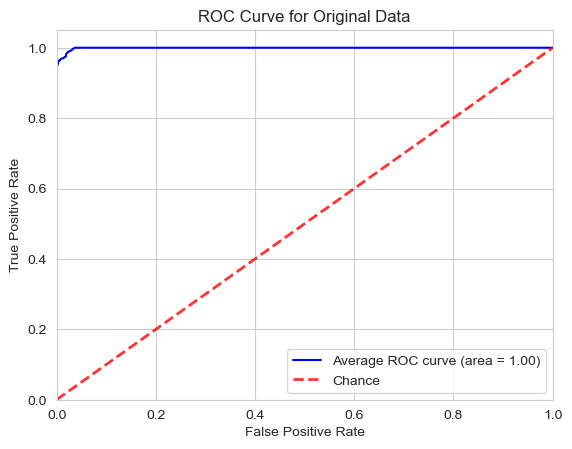

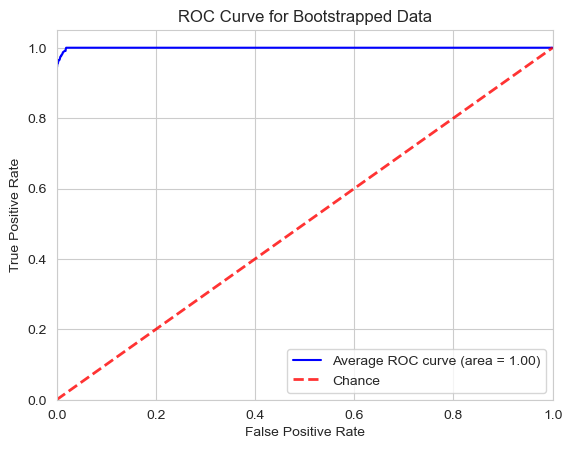

In [15]:
def plot_roc_curve(y_true_bin, X_set_scaled, title):
    # Set the Seaborn style
    sb.set_style("whitegrid")

    # Binarize the output classes for ROC plotting
    n_classes = y_true_bin.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], model.predict_proba(X_set_scaled)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    plt.figure()
    plt.plot(all_fpr, mean_tpr, color='blue',
             label='Average ROC curve (area = {0:0.2f})'.format(np.mean(list(roc_auc.values()))))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Prepare data for ROC
y_bin = label_binarize(y, classes=[0, 1, 2])
y_bootstrapped_bin = label_binarize(y_bootstrapped, classes=[0, 1, 2])

# Plot ROC curves
plot_roc_curve(y_bin, X_scaled, 'ROC Curve for Original Data')
plot_roc_curve(y_bootstrapped_bin, X_bootstrapped_scaled, 'ROC Curve for Bootstrapped Data')

Accuracy: 0.9696620583717358


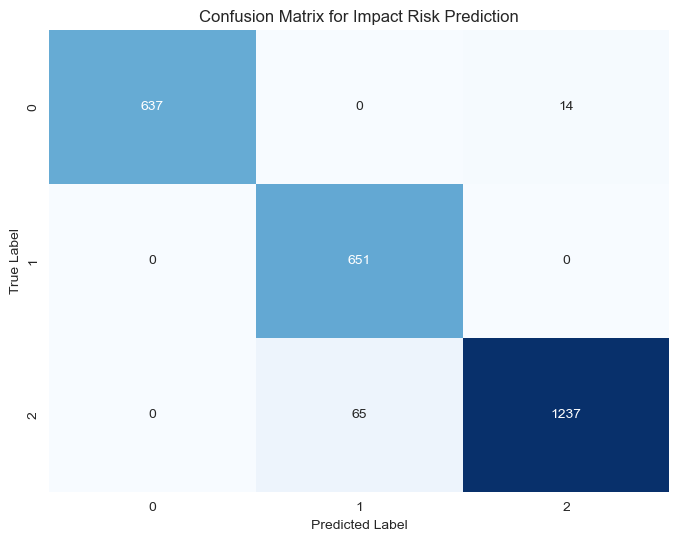

None
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       651
           1       0.91      1.00      0.95       651
           2       0.99      0.95      0.97      1302

    accuracy                           0.97      2604
   macro avg       0.97      0.98      0.97      2604
weighted avg       0.97      0.97      0.97      2604



In [17]:
# Encoding the target variable (IMPACT RISK CATEGORY)
le = LabelEncoder()
train['IMPACT_RISK_ENCODED'] = le.fit_transform(train['IMPACT_RISK_CATEGORY'])

X = train[['IMPACT_RISK', 'HAZARDOUS_ENCODED']]
y = train['IMPACT_RISK_ENCODED']
    
# Feature Scaling for 'IMPACT_RISK' only
train['IMPACT_RISK'] = scaler.fit_transform(train[['IMPACT_RISK']])

# Create a logistic regression model with multinomial option
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# Train the model
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Model evaluation
print("Accuracy:", accuracy_score(y, y_pred))
print(plot_confusion_matrix(y, y_pred, 'Confusion Matrix for Impact Risk Prediction'))
print(classification_report(y, y_pred))